### Load Encoder - BERT

In [1]:
import torch
import numpy as np
from sentence_transformers import SentenceTransformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = SentenceTransformer("all-mpnet-base-v2").to(device)

def encode_captions(captions):
    encoded_captions = {}
    for image_name in captions.keys():
        caption = captions[image_name]
        encoded_captions[image_name] = {
            "embed": torch.tensor(bert_model.encode(caption)),
            "text": caption
        }
    return encoded_captions




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Load dataset

In [2]:
!gdown 1JJjMiNieTz7xYs6UeVqd02M3DW4fnEfU
!unzip cvpr2016_flowers.zip

# Load captions
import os

def load_captions(captions_folder, image_folder):
    captions = {}
    image_files = os.listdir(image_folder)

    for image_file in image_files:
        image_name = image_file.split(".")[0]
        caption_file = os.path.join(captions_folder, image_name + ".txt")

        with open(caption_file, "r") as f:
            caption = f.readlines()[0].strip()

        if image_name not in captions:
            captions[image_name] = caption

    return captions

captions_folder = "./content/cvpr2016_flowers/captions"
image_folder = "./content/cvpr2016_flowers/images"

captions = load_captions(captions_folder, image_folder)



Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: content/cvpr2016_flowers/images/image_02041.jpg  
  inflating: content/cvpr2016_flowers/images/image_06550.jpg  
  inflating: content/cvpr2016_flowers/images/image_00556.jpg  
  inflating: content/cvpr2016_flowers/images/image_05695.jpg  
  inflating: content/cvpr2016_flowers/images/image_02732.jpg  
  inflating: content/cvpr2016_flowers/images/image_00112.jpg  
  inflating: content/cvpr2016_flowers/images/image_03424.jpg  
  inflating: content/cvpr2016_flowers/images/image_03702.jpg  
  inflating: content/cvpr2016_flowers/images/image_01316.jpg  
  inflating: content/cvpr2016_flowers/images/image_03391.jpg  
  inflating: content/cvpr2016_flowers/images/image_02503.jpg  
  inflating: content/cvpr2016_flowers/images/image_05044.jpg  
  inflating: content/cvpr2016_flowers/images/image_01633.jpg  
  inflating: content/cvpr2016_flowers/images/image_05305.jpg  
  inflating: content/cvpr2016_flowers/images/image_02522.jpg 

### Processing data

In [3]:
encoded_captions = encode_captions( captions )


In [15]:
for key in encoded_captions.keys():
    print(key)
    break
print((encoded_captions["image_00128"])["embed"].shape)
# for key in encoded_captions["image_00128"].keys():
#     print(encoded_captions["image_00128"][key])
#     break

image_00128
torch.Size([768])


In [43]:
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


class FlowerDataset(Dataset):
    def __init__(self, img_dir, captions, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        # Load captions
        self.captions = captions
        self.img_names = list(self.captions.keys())

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name + ".jpg")
        image = Image.open(img_path).convert("RGB")


        encoded_caption = self.captions[img_name]["embed"]
        caption = self.captions[img_name]["text"]


        wrong_img = self.img_names[idx]
        if(idx == 8189):
          wrong_img = self.img_names[0]
        else:
          wrong_img = self.img_names[idx + 1]

        img_wrong_path = os.path.join(self.img_dir, wrong_img + ".jpg")
        image_wrong = Image.open(img_wrong_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
            image_wrong = self.transform(image_wrong)

        return {
            "image": image,
            "embed_caption": encoded_caption,
            "text": caption,
            "wrong_image": image_wrong
        }


IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

ds = FlowerDataset(
    img_dir="content/cvpr2016_flowers/images",
    captions=encoded_captions,
    transform=transform
)
# print(len(ds))
item = ds[0]["wrong_image"]
print(item)
BATCH_SIZE = 1024
dataloader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)


tensor([[[-0.6235, -0.6235, -0.6392,  ..., -0.8353, -0.8353, -0.8588],
         [-0.6157, -0.6235, -0.6392,  ..., -0.8275, -0.8275, -0.8510],
         [-0.6157, -0.6314, -0.6549,  ..., -0.8196, -0.8275, -0.8431],
         ...,
         [-0.6392, -0.4824, -0.3176,  ...,  0.0510, -0.1059, -0.3412],
         [-0.7882, -0.6706, -0.4980,  ...,  0.0118, -0.0824, -0.2863],
         [-0.8353, -0.8039, -0.6863,  ..., -0.1922, -0.2157, -0.3961]],

        [[-0.5608, -0.5608, -0.5765,  ..., -0.8118, -0.8196, -0.8431],
         [-0.5529, -0.5608, -0.5765,  ..., -0.8039, -0.8118, -0.8353],
         [-0.5529, -0.5686, -0.5922,  ..., -0.7882, -0.8039, -0.8196],
         ...,
         [-0.5922, -0.4275, -0.2627,  ...,  0.0667, -0.0902, -0.3255],
         [-0.7569, -0.6392, -0.4431,  ...,  0.0275, -0.0667, -0.2784],
         [-0.7961, -0.7647, -0.6471,  ..., -0.1686, -0.2000, -0.4039]],

        [[-0.6784, -0.6784, -0.6863,  ..., -0.9294, -0.9294, -0.9294],
         [-0.6706, -0.6784, -0.6941,  ..., -0

### Generator

In [44]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        # Text Encoder
        self.textEncoder = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        # Upsampling Block
        self.upsamplingBlock = nn.Sequential(
            # 256 + 100 --> 1024
            nn.ConvTranspose2d(noise_size + reduced_dim_size, feature_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # 1024 --> 512
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),
            # 512 --> 256
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),
            # 256 --> 128
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),
            # 128 --> 128
            nn.ConvTranspose2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),
            # 128 --> 3
            nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, text_embeddings):
        encoded_text = self.textEncoder(text_embeddings)
        print("noise: ", noise.shape)
        print("encoded_text: ", encoded_text.shape)
        concat_input = torch.cat([noise, encoded_text], dim=1).unsqueeze(2).unsqueeze(2)
        output = self.upsamplingBlock(concat_input)
        return output


### Descrimnator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        # Image Encoder
        self.imageEncoder = nn.Sequential(
            # 3 -> 128
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 -> 128
            nn.Conv2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 -> 256
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 -> 512
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 512 -> 1024
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Text Encoder
        self.textEncoder = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        # Final Block
        self.finalBlock = nn.Sequential(
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input_img, text_embeddings):
        image_encoded = self.imageEncoder(input_img)
        text_encoded = self.textEncoder(text_embeddings)
        replicated_text = text_encoded.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)
        concat_layer = torch.cat([image_encoded, replicated_text], 1)
        x = self.finalBlock(concat_layer)
        return x.view(-1, 1), image_encoded


### Define Optimizer and Losses

In [45]:
import torch.optim as optim
import torch.nn.functional as F

generator = Generator(100, 128, 3, 768, 256).to(device)
discriminator = Discriminator(3, 128, 768, 256).to(device)

# Initialize optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Losses
bce_loss = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()


### Plot

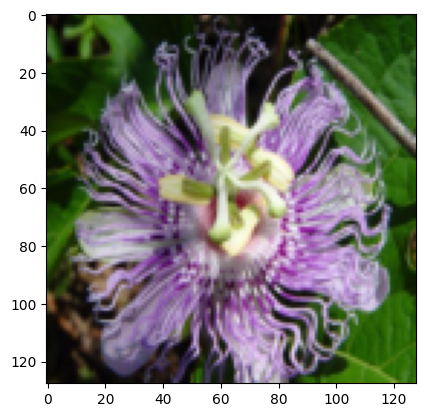

In [46]:
import matplotlib.pyplot as plt
import torchvision
import torch

def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

show_grid(torchvision.utils.make_grid(ds[0]["image"], normalize=True))

def plot_output(generator):
    plt.clf()
    with torch.no_grad():
        generator.eval()
        test_images = generator(fixed_noise.to(device), plt_o_text_embeddings.to(device))
        generator.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)


### Training

In [ ]:
epochs = 200
import time

for epoch in range(epochs):
  d_losses, g_losses = [], []
  epoch_time = time.time()

  for batch in dataloader:
    images = batch["image"].to(device)
    embed_captions = batch["embed_caption"].to(device)
    wrong_images = batch["wrong_image"].to(device)


    real_labels = torch.ones( images.size(0) , 1 , device = device )
    fake_labels = torch.zeros( images.size(0) , 1 , device = device )

    # Training D
    optimizer_D.zero_grad()
    noise = torch.randn( size =( images.size (0) , 100) , device = device )
    fake_images = generator( noise , embed_captions )

    # Compute real loss
    real_loss = bce_loss( discriminator( images , embed_captions )[0] , real_labels )

    # Compute constractive loss
    outputs , _ = discriminator( wrong_images , embed_captions )
    wrong_loss = bce_loss( outputs , fake_labels )

    # Compute fake loss
    outputs, _ = discriminator(fake_images.detach(), embed_captions)
    fake_loss = bce_loss(outputs, fake_labels)

    d_loss = real_loss + fake_loss + wrong_loss

    # Update weight
    d_loss.backward()
    optimizer_D.step()
    d_losses.append(d_loss.item())

    # Training generator
    optimizer_G.zero_grad()

    # Create noise
    noise = torch.randn(size=(images.size(0), 100), device=device)
    fake_images = generator(noise, embed_captions)

    outputs, fake_features = discriminator(fake_images, embed_captions)
    _, real_features = discriminator(images, embed_captions)

    activation_fake = torch.mean(fake_features, 0)
    activation_real = torch.mean(real_features, 0)

    # Compute loss
    real_loss = bce_loss(outputs, real_labels)
    g_loss = real_loss + 100 * l2_loss(activation_fake, activation_real.detach()) + 50 * l1_loss(fake_images, images)

    g_loss.backward()
    optimizer_G.step()
    g_losses.append(real_loss.item())

    avg_d_loss = sum(d_losses) / len(d_losses)
    avg_g_loss = sum(g_losses) / len(g_losses)

    if (epoch + 1) % 10 == 0:
        plot_output(generator)

    print("Epoch [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}".format(
        epoch + 1, epochs, avg_d_loss, avg_g_loss, time.time() - epoch_time))

    # Save model
    model_save_path = "./save_model"
    torch.save(generator.state_dict(), os.path.join(model_save_path, "generator.pth"))
    torch.save(discriminator.state_dict(), os.path.join(model_save_path, "discriminator.pth"))





### Evaluate

In [ ]:
generator.eval()

caption = "this pale pink flower has a large yellow and green pistil."
embed_caption = torch.tensor(bert_model.encode(caption))

noise = torch.randn(size=(1, 100))

text_embedding = embed_caption.unsqueeze(0)

with torch.no_grad():
    test_images = generator(noise.to(device), text_embedding.to(device))

grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
show_grid(grid)
